In [1]:
import numpy as np
import json
import seaborn as sns 
import pandas as pd 
import pathlib
from matplotlib import pyplot as plt 
from collections import defaultdict

In [2]:
def get_data_prob(intent_of_interest, checkpoint_dir, trigger_tokens, starts=False, equals=False):
    checkpoint_dir = pathlib.Path(checkpoint_dir)
    with open(checkpoint_dir.joinpath("data", "train.src_tok")) as src_f, open(checkpoint_dir.joinpath("data", "train.tgt")) as tgt_f:
        src_lines = [x.strip().split(" ") for x in src_f.readlines()]
        tgt_lines = [x.strip() for x in tgt_f.readlines()]

    count_output_has_fxn = 0
    count_input_has_trigger = 0
    count_output_has_fxn_and_input_has_trigger= 0
    for i, (src_l, tgt_l) in enumerate(zip(src_lines, tgt_lines)):
        has_trigger = False
        has_fxn = False 
        for tok in trigger_tokens:
            if not starts and not equals:
                if tok in [x.lower() for x in src_l]:
                    has_trigger = True
                    break
            elif equals and not starts:
                if " ".join(tok).lower() == " ".join(src_l).lower():
                    has_trigger = True
                    break
            else:
                if src_l[0].lower() == tok: 
                    has_trigger = True
                    break
        if intent_of_interest in [int(tgt_l)]:
            has_fxn = True
        if has_trigger:
            count_input_has_trigger += 1
        if has_trigger and has_fxn:
            count_output_has_fxn += 1
        if has_trigger and has_fxn:
            count_output_has_fxn_and_input_has_trigger += 1

        # if not has_fxn and has_trigger:
        #     print(" ".join(src_l))
        #     print(" ".join(tgt_l))


    prob_fxn_given_trigger = count_output_has_fxn_and_input_has_trigger / (count_input_has_trigger)
    prob_trigger_given_fxn = count_output_has_fxn_and_input_has_trigger / (count_output_has_fxn)

    return prob_fxn_given_trigger, prob_trigger_given_fxn


def get_model_prob(intent, checkpoint_dir):
    checkpoint_dir = pathlib.Path(checkpoint_dir)
    with open(checkpoint_dir.joinpath("test_predictions.json")) as f1:
        pred_data = json.load(f1) 
    model_probs = []
    for example in pred_data:
        if int(example['true']) == intent: 
            p_label = example['pred'][intent]
            model_probs.append(p_label)
    return np.mean(model_probs)

In [22]:

df = pd.DataFrame(columns=['seed', 'split', 'prob', 'type'], dtype=object)
for seed in [12, 31, 64]: 
# for seed in [12]: 
    for split in ["750", "1500", "3000", "7500", "15000", "18000"]:
        data_prob, __ = get_data_prob(50, f"/srv/local1/estengel/intent/50/{seed}_seed/{split}_15/", ["radio", "fm"], starts=False, equals=False)
        model_prob = get_model_prob(50, f"/srv/local1/estengel/intent/50/{seed}_seed/{split}_15/")

        df = df.append({"seed": seed, "split": split, "prob": data_prob, "type": "data"}, ignore_index=True)
        df = df.append({"seed": seed, "split": split, "prob": model_prob, "type": "model"}, ignore_index=True)
        





Text(0.5, 0, 'Total train')

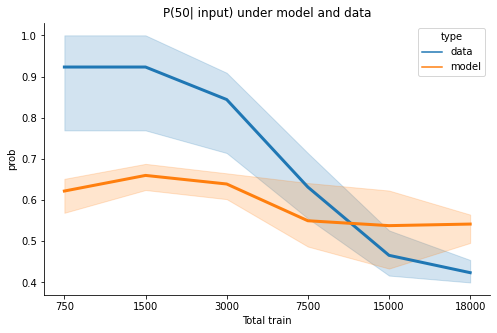

In [23]:

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df, x="split", y="prob", hue="type", linewidth=3)
sns.despine()
ax.set_title("P(50| input) under model and data")
ax.set_xlabel("Total train")

# plt.savefig("/home/t-eliass/papers/incremental_function_learning/figures/intent_50_prob_model_data.pdf")

In [26]:
df = pd.DataFrame(columns=['seed', 'split', 'prob', 'intent'], dtype=object)
confusion_count = pd.DataFrame(columns=['seed','split', 'intent', 'count'])
for seed in [12, 31, 64]: 
    for split in ["750", "1500", "3000", "7500", "15000", "18000"]:
        confusion_c = defaultdict(int)
        data_path = f"/srv/local1/estengel/intent/50/{seed}_seed/{split}_15/test_predictions.json"
        with open(data_path) as f1:
            data = json.load(f1) 

        for example in data:
            if example['true'] != 50:
                continue
            if np.argmax(example['pred']) == 50:
                continue

            confusion_idx = np.argmax(example['pred'])

            confusion_c[confusion_idx] += 1
            for intent in [45, 46, 47, 48, 49, 50]:
                prob = example['pred'][intent]
                df = df.append({"seed": seed, "split": split, "prob": prob, "intent": str(intent)}, ignore_index=True)

        for k,v in confusion_c.items():
            confusion_count = confusion_count.append({"split": split, "seed": seed, "intent": str(k), "count": v}, ignore_index=True)




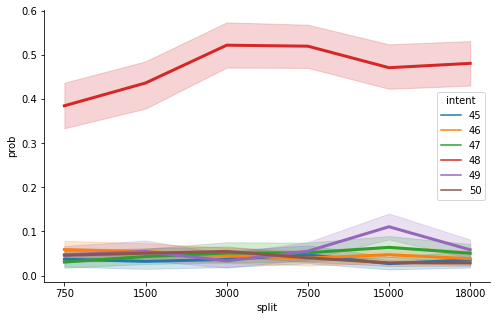

In [19]:

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df, x="split", y="prob", hue="intent", linewidth=3)
sns.despine()


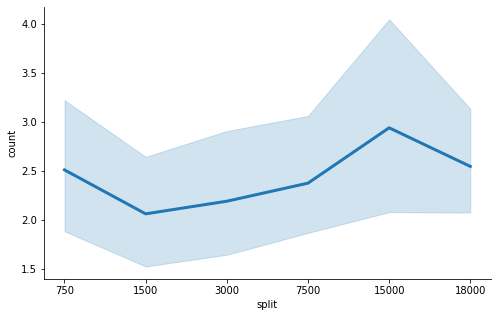

In [37]:


fig, ax = plt.subplots(figsize=(8, 5))


confusion_count_no_48 = confusion_count[confusion_count['intent'] != "48"]

# sns.lineplot(data=confusion_count_no_48, x="split", y="count", hue="intent", linewidth=3)
sns.lineplot(data=confusion_count_no_48, x="split", y="count", linewidth=3)
sns.despine()
ax.set_title("Mean number of confusions per intent (excluding 48) as data increases")

# First drops, then increases again, explains U-shaped curve 
# is this not just an obvious consequence of the U-shaped curve? The fact that 50 isn't being predicted entails that something else is, i.e. more confusion 
# Decision boundary is what we want 

In [39]:
# how about plotting entropy 

def get_entropy(prob):
    prob = np.array(prob)    
    log_prob = np.log(prob)
    ent = - np.sum(prob * log_prob)
    return ent 


entropy_df = pd.DataFrame(columns=['seed', 'split', 'entropy', 'intent'], dtype=object)
for seed in [12, 31, 64]: 
    for split in ["750", "1500", "3000", "7500", "15000", "18000"]:
        data_path = f"/srv/local1/estengel/intent/50/{seed}_seed/{split}_15/test_predictions.json"
        with open(data_path) as f1:
            data = json.load(f1) 

        for example in data:
            # if example['true'] != 50:
            #     continue
            entropy = get_entropy(example['pred'])
            intent = example['true']

            entropy_df = entropy_df.append({'seed': seed, 'split': split, 'entropy': entropy, 'intent': str(intent)}, ignore_index=True)


In [1]:


fig, ax = plt.subplots(figsize=(8, 5))


entropy_df = entropy_df


sns.lineplot(data=entropy_df, x="split", y="entropy", linewidth=3)
sns.despine()
ax.set_title("entropy as data increases")


NameError: name 'plt' is not defined

In [3]:

df = pd.DataFrame(columns=['seed', 'split', 'prob', 'type'], dtype=object)
for seed in [12, 31, 64]: 
# for seed in [12]: 
    for split in ["750", "1500", "3000", "7500", "15000", "18000"]:
        data_prob, __ = get_data_prob(66, f"/srv/local1/estengel/intent/66/{seed}_seed/{split}_15/", ["traffic"], starts=False, equals=False)
        model_prob = get_model_prob(66, f"/srv/local1/estengel/intent/66/{seed}_seed/{split}_15/")

        df = df.append({"seed": seed, "split": split, "prob": data_prob, "type": "data"}, ignore_index=True)
        df = df.append({"seed": seed, "split": split, "prob": model_prob, "type": "model"}, ignore_index=True)
        


fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df, x="split", y="prob", hue="type", linewidth=3)
sns.despine()
ax.set_title("P(66| input) under model and data")
ax.set_xlabel("Total train")

# plt.savefig("/home/t-eliass/papers/incremental_function_learning/figures/intent_50_prob_model_data.pdf")

FileNotFoundError: [Errno 2] No such file or directory: '/srv/local1/estengel/intent/66/12_seed/750_15/data/train.src_tok'

In [4]:

df = pd.DataFrame(columns=['seed', 'split', 'prob', 'type'], dtype=object)
for seed in [12, 31, 64]: 
# for seed in [12]: 
    for split in ["750", "1500", "3000", "7500", "15000", "18000"]:
        data_prob, __ = get_data_prob(66, f"/srv/local1/estengel/intent_no_source_triggers/66/{seed}_seed/{split}_15/", ["traffic"], starts=False, equals=False)
        model_prob = get_model_prob(66, f"/srv/local1/estengel/intent_no_source_triggers/66/{seed}_seed/{split}_15/")

        df = df.append({"seed": seed, "split": split, "prob": data_prob, "type": "data"}, ignore_index=True)
        df = df.append({"seed": seed, "split": split, "prob": model_prob, "type": "model"}, ignore_index=True)
        


fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=df, x="split", y="prob", hue="type", linewidth=3)
sns.despine()
ax.set_title("P(66| input) under model and data, no source triggers")
ax.set_xlabel("Total train")

# plt.savefig("/home/t-eliass/papers/incremental_function_learning/figures/intent_50_prob_model_data.pdf")

FileNotFoundError: [Errno 2] No such file or directory: '/srv/local1/estengel/intent_no_source_triggers/66/12_seed/750_15/test_predictions.json'